# Exploratory Data Analysis: Multi-User Behavioural Biometrics

This notebook performs exploratory analysis on window-level behavioural features derived from typing and tapping tasks.

The objectives are to:
- characterise global feature distributions
- assess inter-individual variability
- assess intra-individual stability across sessions
- examine missingness as a behavioural signal

No predictive modelling or machine learning is performed in this notebook.

In [24]:
import glob
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [25]:
def find_sessions_dir(start: Path) -> Path:
    """
    Walk upwards until we find data/raw/sessions
    """
    for p in [start] + list(start.parents):
        candidate = p / "data" / "raw" / "sessions"
        if candidate.exists():
            return candidate
    raise FileNotFoundError("Could not find data/raw/sessions")

SESSIONS_DIR = find_sessions_dir(Path.cwd())
print(f"Using sessions dir: {SESSIONS_DIR}")

AUTH_GLOB = str(SESSIONS_DIR / "*" / "auth_windows.csv")
files = sorted(glob.glob(AUTH_GLOB))

assert files, "No auth_windows.csv files found"

dfs = []
for f in files:
    df = pd.read_csv(f)
    df["sessionFolder"] = Path(f).parent.name
    dfs.append(df)

auth = pd.concat(dfs, ignore_index=True)

print("Participants:", auth["participantId"].nunique())
print("Sessions:", auth["sessionId"].nunique())
print("Windows:", len(auth))

display(auth.head())

Using sessions dir: /Users/will/Documents/Behavioural-Biometrics-Data-Collection/Behavioural-Biometrics-Analysis/data/raw/sessions
Participants: 1
Sessions: 3
Windows: 21


,sessionId,participantId,sessionIndex,timeBucket,fatigue,inputDevice,typing_ikt_global_mean,typing_ikt_global_std,typing_ikt_global_iqr,typing_ikt_global_p95,...,tap_miss_rate_pct,tap_drift_rt,tap_error_recovery_miss_median,coupling_var_ikt,coupling_var_rt,coupling_var_ratio,windowIndex,windowStartMs,windowEndMs,sessionFolder
0,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,309.0,335.0,150.0,1116.0,...,0,NaN,NaN,112481.943346,NaN,NaN,0,456075,486075,3be79cb28ce24d35b5b4c16cc51f8aac
1,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,277.0,325.0,98.0,1090.0,...,0,NaN,NaN,105496.999909,NaN,NaN,1,471075,501075,3be79cb28ce24d35b5b4c16cc51f8aac
2,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,303.0,353.0,122.0,1111.0,...,0,NaN,NaN,124409.280273,NaN,NaN,2,486075,516075,3be79cb28ce24d35b5b4c16cc51f8aac
3,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,359.0,385.0,333.0,1122.0,...,13,NaN,NaN,147866.510191,120634.987500,0.816,3,501075,531075,3be79cb28ce24d35b5b4c16cc51f8aac
4,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,NaN,NaN,NaN,NaN,...,8,-177.0,NaN,NaN,65104.245747,NaN,4,516075,546075,3be79cb28ce24d35b5b4c16cc51f8aac


## Global Feature Distributions

We first examine the marginal distributions of timing-based behavioural features across all users and sessions.

This establishes scale, skewness, and plausibility of engineered features.

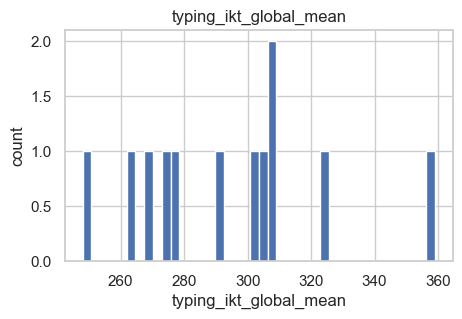

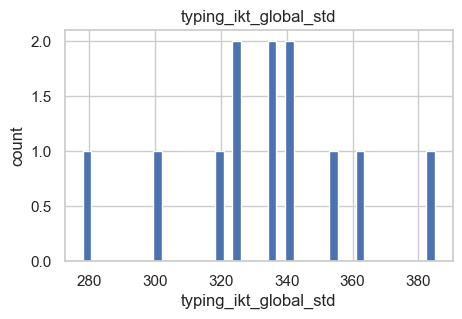

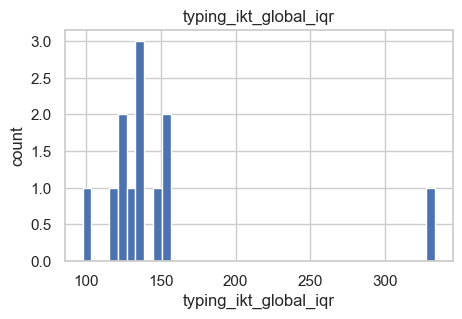

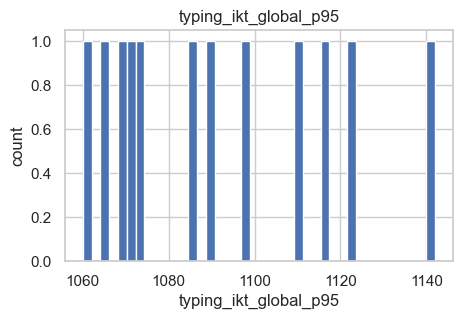

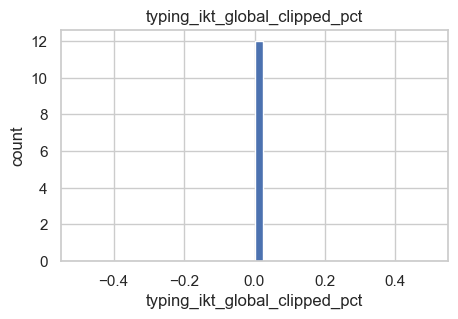

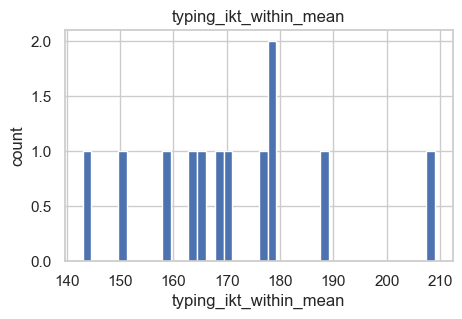

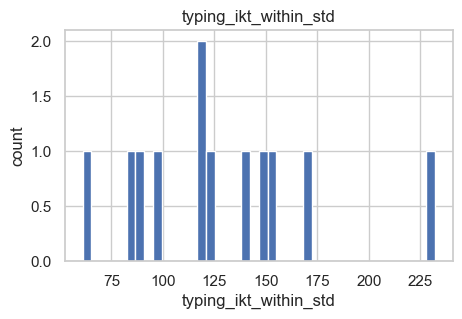

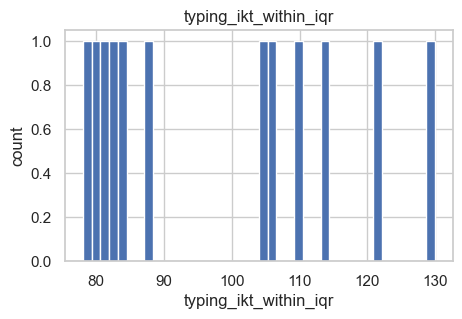

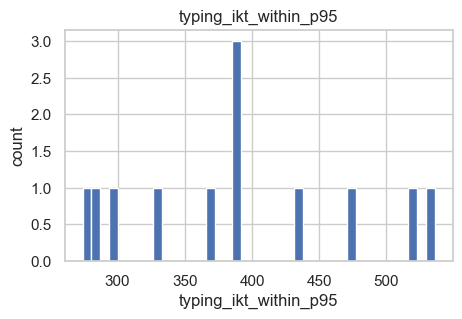

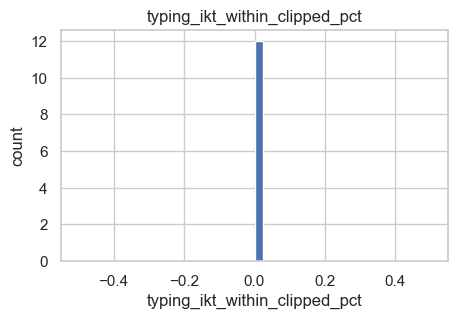

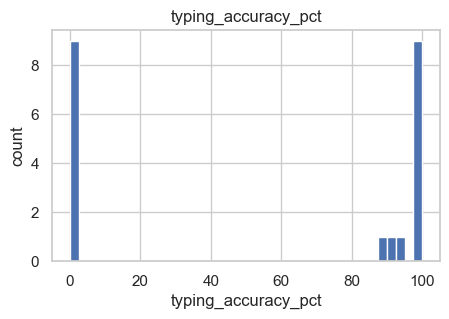

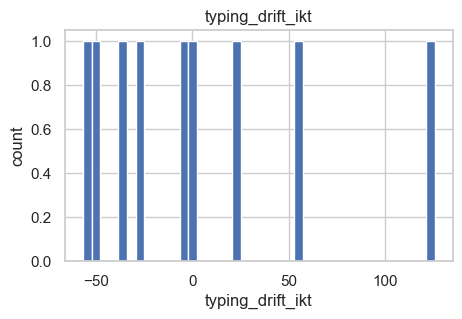

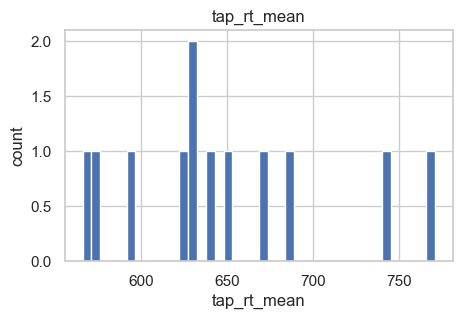

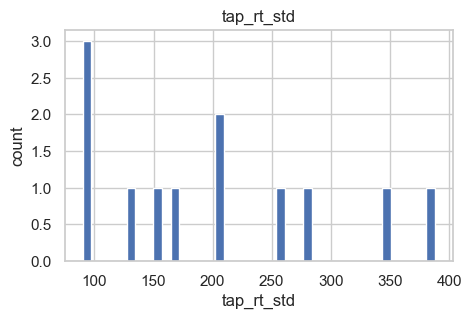

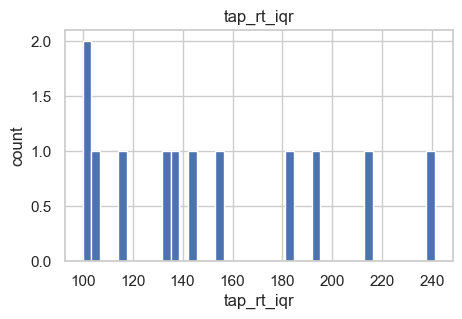

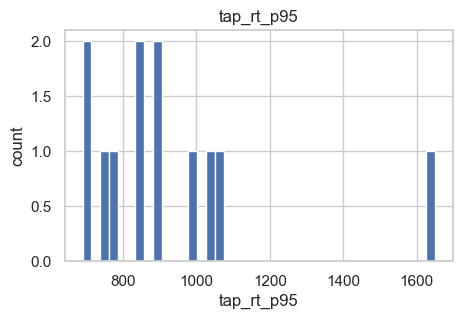

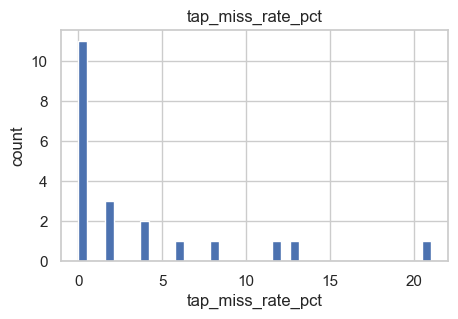

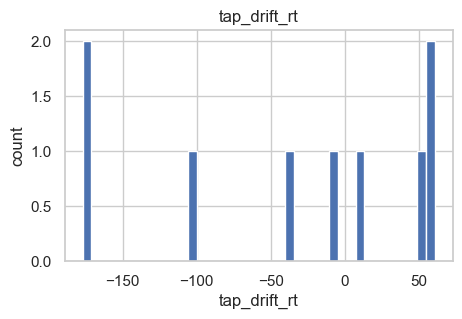

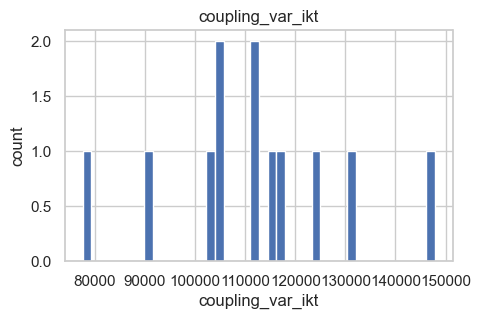

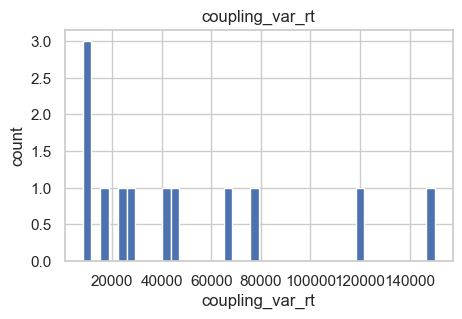

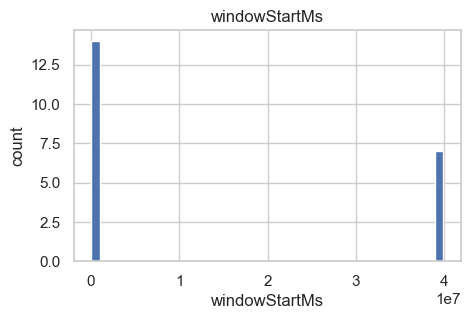

In [26]:
num_cols = auth.select_dtypes(include=[np.number]).columns

PLOT_COLS = [
    c for c in num_cols
    if any(k in c for k in ["ikt", "rt", "pct"])
]

for c in PLOT_COLS:
    data = auth[c].dropna()
    if len(data) == 0:
        continue
    plt.figure(figsize=(5,3))
    plt.hist(data, bins=40)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()

## Per-User Feature Distributions

We next examine whether different participants exhibit systematically different distributions for the same behavioural features.

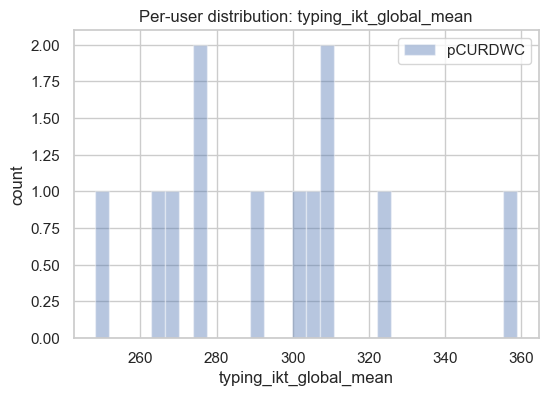

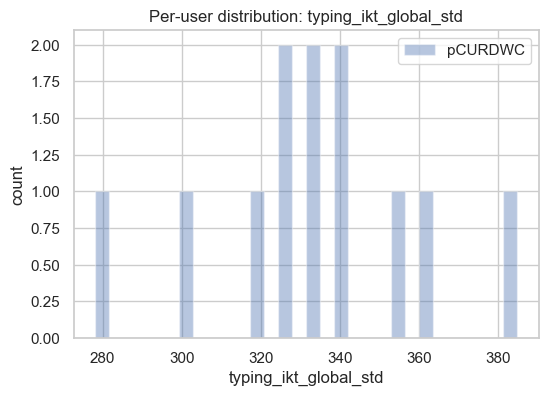

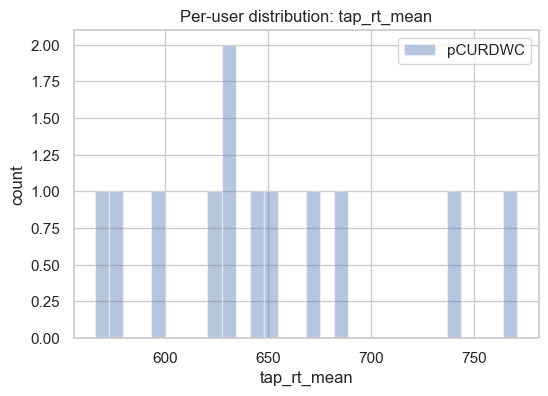

In [27]:
FEATURES_TO_COMPARE = [
    "typing_ikt_global_mean",
    "typing_ikt_global_std",
    "tap_rt_mean"
]

for feat in FEATURES_TO_COMPARE:
    if feat not in auth.columns:
        continue

    plt.figure(figsize=(6,4))
    for pid, g in auth.groupby("participantId"):
        plt.hist(g[feat].dropna(), bins=30, alpha=0.4, label=pid)

    plt.title(f"Per-user distribution: {feat}")
    plt.xlabel(feat)
    plt.ylabel("count")
    plt.legend()
    plt.show()

## Within-User vs Between-User Variability

We compare variability of behavioural features within the same participant to variability observed between different participants.

In [28]:
rows = []

for feat in FEATURES_TO_COMPARE:
    if feat not in auth.columns:
        continue

    for pid, g in auth.groupby("participantId"):
        rows.append({
            "feature": feat,
            "participantId": pid,
            "within_var": g[feat].var(),
            "mean": g[feat].mean()
        })

var_df = pd.DataFrame(rows)

display(var_df)

,feature,participantId,within_var,mean
0,typing_ikt_global_mean,pCURDWC,910.242424,294.333333
1,typing_ikt_global_std,pCURDWC,765.537879,333.583333
2,tap_rt_mean,pCURDWC,3860.810606,648.416667


## Session-to-Session Stability

We examine whether behavioural features remain relatively stable for the same participant across multiple sessions.

In [29]:
session_means = (
    auth.groupby(["participantId","sessionId"])[FEATURES_TO_COMPARE]
        .mean()
        .reset_index()
)

display(session_means)

,participantId,sessionId,typing_ikt_global_mean,typing_ikt_global_std,tap_rt_mean
0,pCURDWC,3be79cb28ce24d35b5b4c16cc51f8aac,312.00,349.50,652.00
1,pCURDWC,b30211d252ca488692fd9dec68fbf740,283.25,330.50,614.50
2,pCURDWC,cf7e7dad28b94d1f849c4e5e9eb7bc45,287.75,320.75,678.75


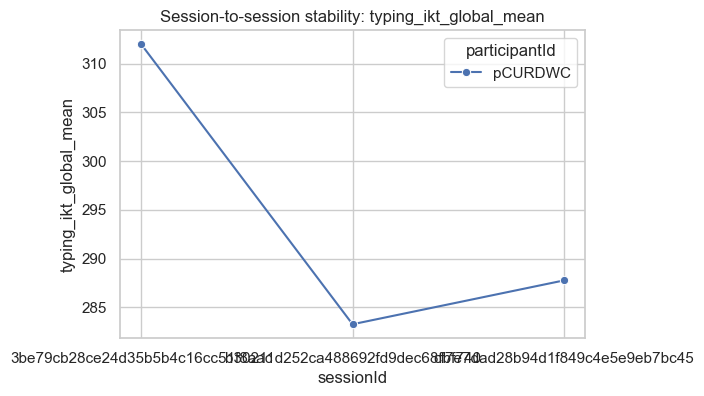

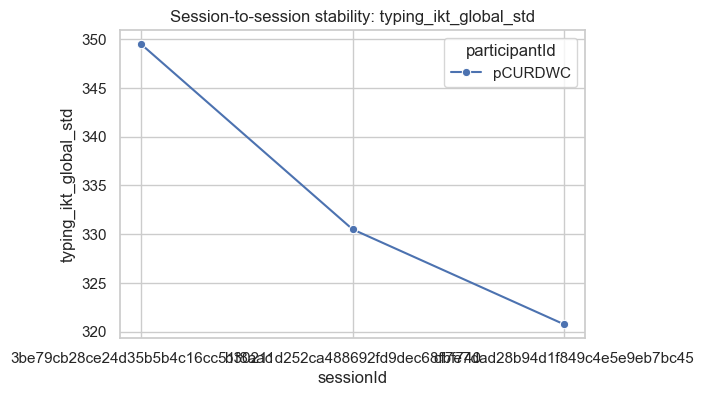

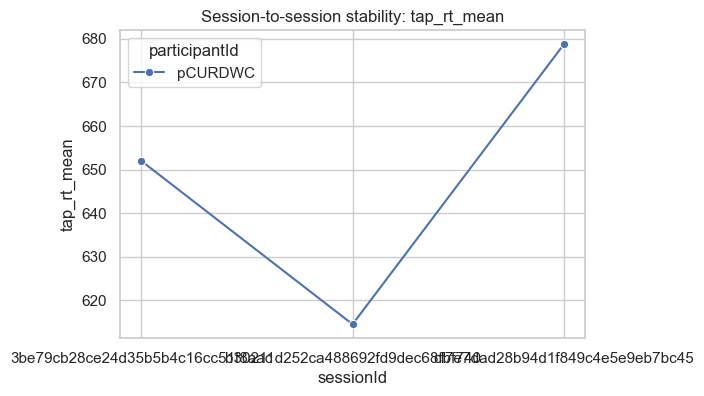

In [30]:
for feat in FEATURES_TO_COMPARE:
    plt.figure(figsize=(6,4))
    sns.lineplot(
        data=session_means,
        x="sessionId",
        y=feat,
        hue="participantId",
        marker="o"
    )
    plt.title(f"Session-to-session stability: {feat}")
    plt.show()

## Missingness Patterns

Missing values are expected for features that depend on the occurrence of specific behaviours (e.g. errors, drift). We examine missingness as an informative signal rather than a data defect.

In [31]:
num = auth.select_dtypes(include=[np.number])
miss = num.isna().mean().sort_values(ascending=False)

display(miss.head(20))

tap_error_recovery_miss_median        1.000000
typing_error_recovery_wrong_median    1.000000
coupling_var_ratio                    0.857143
typing_drift_ikt                      0.571429
tap_drift_rt                          0.571429
typing_ikt_within_std                 0.428571
typing_ikt_global_clipped_pct         0.428571
typing_ikt_within_iqr                 0.428571
typing_ikt_global_std                 0.428571
typing_ikt_global_mean                0.428571
typing_ikt_global_p95                 0.428571
typing_ikt_global_iqr                 0.428571
coupling_var_rt                       0.428571
coupling_var_ikt                      0.428571
typing_ikt_within_clipped_pct         0.428571
typing_ikt_within_p95                 0.428571
typing_ikt_within_mean                0.428571
tap_rt_p95                            0.428571
tap_rt_mean                           0.428571
tap_rt_std                            0.428571
dtype: float64

## Summary Statistics

We summarise key statistics per participant to support interpretationand downstream modelling decisions.


In [32]:
summary = (
    auth.groupby("participantId")[FEATURES_TO_COMPARE]
        .agg(["mean","std","median"])
)

display(summary)

typing_ikt_global_mean                   typing_ikt_global_std  \
                                mean        std median                  mean   
participantId                                                                  
pCURDWC                   294.333333  30.170224  296.5            333.583333   

                                tap_rt_mean                    
                     std median        mean        std median  
participantId                                                  
pCURDWC        27.668355  335.0  648.416667  62.135422  636.0

## EDA Summary

Exploratory analysis reveals:
- substantial inter-individual variation in timing-based features
- relatively stable within-participant behaviour across sessions
- structured missingness aligned with behavioural interpretation

These observations support the hypothesis that window-level behavioural features contain identity-specific structure, motivating subsequent authentication modelling.
